In [28]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
data = pd.read_csv('./FE_data/data.csv')

In [4]:
data.shape

(1815515, 22)

In [5]:
pd.set_option('display.max_columns', None)
data.head()

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,is_create_role,is_create_no,server_sum,30d_pay_money
0,11265111,3,1,1,0.02,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,11265397,4,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,11269078,4,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,11271222,12,1,1,0.02,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,11280270,20,1,4,3.37,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [6]:
data.describe()

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,is_create_role,is_create_no,server_sum,30d_pay_money
count,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06,1.815515e+06
mean,7.936047e+07,1.283722e+01,1.006964e+00,2.607677e+00,4.346908e+00,1.359905e+01,2.948645e-01,2.298178e+01,1.927828e-05,3.800574e-04,2.944867e-01,2.280988e+01,1.491890e+00,3.105498e+00,1.003528e+00,1.104513e-01,1.329915e-01,4.296302e-04,9.095265e-01,8.423643e-01,1.917933e+00,5.265065e+01
std,6.604675e+07,2.221300e+01,9.299578e-02,3.628653e+00,9.528667e+00,2.263735e+01,2.088880e+00,3.623503e+02,4.752133e-03,9.907198e-02,2.087605e+00,3.592132e+02,4.999344e-01,7.356371e+00,5.929149e-02,3.134515e-01,1.090634e+00,2.722505e-02,2.868590e-01,3.643992e-01,6.825591e+00,9.712338e+02
min,1.124468e+07,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.223828e+07,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.330657e+08,4.000000e+00,1.000000e+00,1.000000e+00,3.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,1.449490e+08,1.200000e+01,1.000000e+00,2.000000e+00,4.430000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,1.526060e+08,4.860000e+02,4.000000e+00,1.180000e+02,8.448000e+01,2.850000e+02,1.400000e+02,5.432400e+04,2.000000e+00,3.000000e+01,1.400000e+02,5.432400e+04,2.000000e+00,4.400000e+01,2.000000e+00,1.000000e+00,1.820000e+02,8.000000e+00,1.000000e+00,1.000000e+00,6.150000e+02,1.567880e+05


In [7]:
data_train, data_test = train_test_split(data, test_size=0.2)

In [8]:
# 判断train\test中有重复的role_id
a = np.intersect1d(data_train['role_id'], data_test['role_id'])
len(a)

0

In [9]:
data_train.drop(['role_id'], axis=1, inplace=True)
data_test.drop(['role_id'], axis=1, inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
data_train['30d_pay_money'].value_counts()

0.0        1353198
12.0         24894
30.0          7300
42.0          6969
48.0          2798
            ...   
2670.0           1
2668.0           1
42662.0          1
42634.0          1
2262.0           1
Name: 30d_pay_money, Length: 4752, dtype: int64

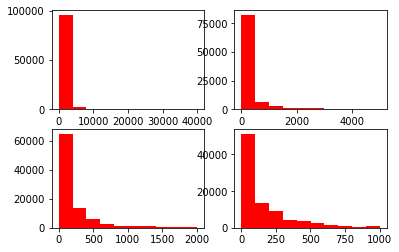

<Figure size 1600x800 with 0 Axes>

In [11]:
# 查看目标值的分布情况，大部分在4000以下
fig, axes = plt.subplots(2, 2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
fig = plt.figure(figsize=(20,10),dpi=80)
ax1.hist(data_train['30d_pay_money'], color='red', range=(1, 40000))
ax2.hist(data_train['30d_pay_money'], color='red', range=(1, 5000))
ax3.hist(data_train['30d_pay_money'], color='red', range=(1, 2000))
ax4.hist(data_train['30d_pay_money'], color='red', range=(1, 1000))
plt.show()

In [45]:
label = '30d_pay_money'
x = data_train.drop([label], axis=1).values
y = data_train[label].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
mmscaler = MinMaxScaler()
x_train = mmscaler.fit_transform(x_train)
x_val = mmscaler.transform(x_val)

In [51]:
y_train_ln = np.log1p(y_train)

(array([1.082444e+06, 1.600000e+01, 2.590000e+04, 1.722600e+04,
        1.949600e+04, 9.992000e+03, 4.096000e+03, 1.935000e+03,
        7.130000e+02, 1.110000e+02]),
 array([ 0.        ,  1.19626562,  2.39253125,  3.58879687,  4.78506249,
         5.98132812,  7.17759374,  8.37385936,  9.57012499, 10.76639061,
        11.96265623]),
 <a list of 10 Patch objects>)

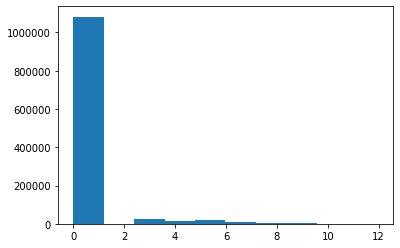

In [54]:
plt.hist(y_train_ln)

In [35]:
print(target_train_ln)

[0. 0. 0. ... 0. 0. 0.]


In [52]:
# 简单LR线性回归

model = LinearRegression()
model.fit(x_train, y_train_ln)
y_predict = np.expm1(model.predict(x_val))
# y_val = np.expm1(y_val)
mse = mean_squared_error(y_predict, y_val)
rmse = mse ** 0.5
print(rmse)
print(mse)

2933612922.4834466
8.606084778961868e+18


In [12]:
label = '30d_pay_money'
x = data_train.drop([label], axis=1).values
y = data_train[label].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbdt=GradientBoostingRegressor(
  loss='ls'
, learning_rate=0.1
, n_estimators=100
, subsample=1
, min_samples_split=2
, min_samples_leaf=1
, max_depth=3
, init=None
, random_state=None
, max_features=None
, alpha=0.9
, verbose=0
, max_leaf_nodes=None
, warm_start=False
)
gbdt.fit(x_train, y_train)
y_predict = gbdt.predict(x_val)
mse = mean_squared_error(y_predict, y_val)
rmse = mse ** 0.5
print(rmse)
print(mse)

615.3900651812239
378704.93232375104


In [20]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=2000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's l1: 93.1291	training's l2: 835028	valid_1's l1: 98.3217	valid_1's l2: 1.09311e+06
Training until validation scores don't improve for 100 rounds
[2]	training's l1: 88.7581	training's l2: 777933	valid_1's l1: 93.7241	valid_1's l2: 1.02008e+06
[3]	training's l1: 84.5963	training's l2: 726471	valid_1's l1: 89.3628	valid_1's l2: 957256
[4]	training's l1: 80.7372	training's l2: 679858	valid_1's l1: 85.3013	valid_1's l2: 898324
[5]	training's l1: 76.9835	training's l2: 637334	valid_1's l1: 81.3724	valid_1's l2: 845970
[6]	training's l1: 73.4408	training's l2: 599236	valid_1's l1: 77.6483	valid_1's l2: 798022
[7]	training's l1: 70.0941	training's l2: 564898	valid_1's l1: 74.1422	valid_1's l2: 755631
[8]	training's l1: 66.9202	training's l2: 534021	valid_1's l1: 70.8197	valid_1's l2: 717879
[9]	training's l1: 63.9103	training's l2: 506102	valid_1's l1: 67.695	valid_1's l2: 683325
[10]	training's l1: 61.1071	training's l2: 480540	valid_1's l1: 64.8205	valid_1's l2: 652258
[11]	tra

[91]	training's l1: 28.3909	training's l2: 185603	valid_1's l1: 33.7804	valid_1's l2: 349889
[92]	training's l1: 28.3614	training's l2: 185201	valid_1's l1: 33.7817	valid_1's l2: 350048
[93]	training's l1: 28.2882	training's l2: 184890	valid_1's l1: 33.7232	valid_1's l2: 350111
[94]	training's l1: 28.2541	training's l2: 184450	valid_1's l1: 33.7119	valid_1's l2: 349898
[95]	training's l1: 28.204	training's l2: 184110	valid_1's l1: 33.6864	valid_1's l2: 349766
[96]	training's l1: 28.1855	training's l2: 183773	valid_1's l1: 33.6855	valid_1's l2: 349794
[97]	training's l1: 28.168	training's l2: 183460	valid_1's l1: 33.6897	valid_1's l2: 350095
[98]	training's l1: 28.1106	training's l2: 183176	valid_1's l1: 33.6542	valid_1's l2: 350562
[99]	training's l1: 28.097	training's l2: 182935	valid_1's l1: 33.6608	valid_1's l2: 350916
[100]	training's l1: 28.0488	training's l2: 182677	valid_1's l1: 33.6382	valid_1's l2: 351203
[101]	training's l1: 28.0264	training's l2: 182105	valid_1's l1: 33.6343

In [22]:
y_predict = model.predict(x_val)
mse = mean_squared_error(y_predict, y_val)
rmse = mse ** 0.5
print(rmse)
print(mse)


590.3343384233301
348494.6311217109


In [29]:
mae = mean_absolute_error(y_predict, y_val)

In [30]:
mae

34.15133092796782

In [31]:
print(y_predict.sum())
print(y_val.sum())

16178179.171163559
16553008.0


In [32]:
(y_val.sum()-y_predict.sum())/y_val.sum()

0.022644151977479925